# Assignment 3: Hough Transform for Line Detection
**Student:** Alireza Mohammadshafie

## How to Execute the Program:
# 1. Install required libraries: pip install opencv-python numpy matplotlib
# 2. Place dal.jpg image file in the same folder as this notebook
# 3. Run all cells in sequence (Cell → Run All)
# 4. The program will:
#    - Load the dal.jpg image
#    - Apply Hough transform to detect lines with minimum length
#    - Apply extended function to detect lines with width
#    - Display the original image with detected lines overlaid
# 5. Results will show:
#    - Number of lines detected with minimum length
#    - Number of lines detected with width filtering
#    - Visual representation of detected lines


In [20]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline



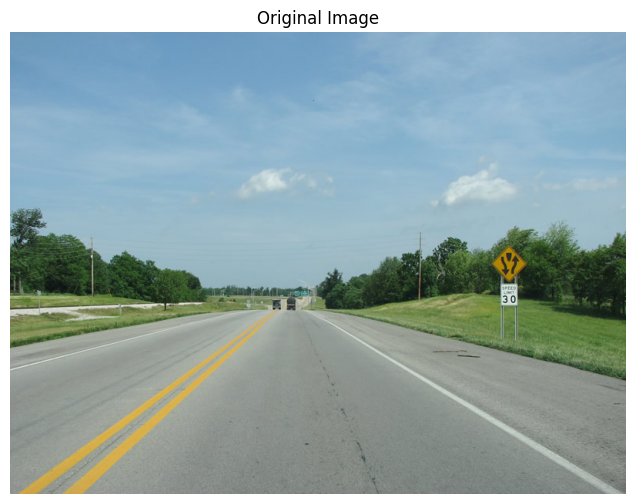

Image shape: (600, 800, 3)


In [21]:
# Load image
image = cv2.imread('dal.png')

plt.figure(figsize=(10, 6))
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')
plt.show()

print(f"Image shape: {image.shape}")


## Hough Transform Function for Line Detection with Minimum Length
This function implements the Hough transform to detect straight lines of at least a certain length.


In [22]:
# Task 1: Function to detect lines with minimum length
def detect_lines(image, min_length):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Step 2: Use Canny to find edges
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)  # 50, 150: hysteresis thresholds

    # Step 3: Detect line segments with minLineLength parameter (in pixels)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=68, minLineLength=min_length, maxLineGap=500)

    return lines ,gray

# Task 2: Function to detect lines with width (geometric width estimation)
def detect_lines_with_width(image, min_length, line_width, width_tolerance=2, samples=11, max_search=100):
    # Step 1: Get candidate lines using Hough transform
    lines , gray = detect_lines(image, min_length)
    
    # Step 2: Show all detected lines first
    vis = image.copy()
    if lines is not None:
        for l in lines:
            x1, y1, x2, y2 = l[0]
            cv2.line(vis, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f'Detected Lines (length ≥ {min_length})')
    plt.axis('off')
    plt.show()
    # Binary mask to measure geometric width (foreground=1)
    _, bin_mask = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)


    def measure_median_width(mask, x1, y1, x2, y2):
        dx = x2 - x1
        dy = y2 - y1
        length = np.hypot(dx, dy)
        if length < 1:
            return 0
        # Unit perpendicular
        ux = -dy / length
        uy = dx / length
        widths = []
        # Sample a few points along the segment
        for t in np.linspace(0.1, 0.9, samples):
            cx = x1 + t * dx
            cy = y1 + t * dy
            # Walk along perpendicular both directions to count contiguous foreground
            w = 1  # count the center pixel
            # Positive direction
            for s in range(1, max_search + 1):
                px = int(round(cx + ux * s))
                py = int(round(cy + uy * s))
                if px < 0 or py < 0 or px >= mask.shape[1] or py >= mask.shape[0]:
                    break
                if mask[py, px] == 0:
                    break
                w += 1
            # Negative direction
            for s in range(1, max_search + 1):
                px = int(round(cx - ux * s))
                py = int(round(cy - uy * s))
                if px < 0 or py < 0 or px >= mask.shape[1] or py >= mask.shape[0]:
                    break
                if mask[py, px] == 0:
                    break
                w += 1
            widths.append(w)
        if len(widths) == 0:
            return 0
        return float(np.median(widths))

    filtered_lines = []
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            # Length check (already enforced by Hough, but keep for clarity)
            seg_len = np.hypot(x2 - x1, y2 - y1)
            if seg_len < min_length:
                continue
            med_width = measure_median_width(bin_mask, x1, y1, x2, y2)
            if abs(med_width - line_width) <= width_tolerance:
                filtered_lines.append((x1, y1, x2, y2))

    # --- Visualize filtered lines ---
    vis_filtered = image.copy()
    for x1, y1, x2, y2 in filtered_lines:
        cv2.line(vis_filtered, (x1, y1), (x2, y2), (0, 255, 255), 2)
    plt.figure(figsize=(8, 4))
    plt.imshow(cv2.cvtColor(vis_filtered, cv2.COLOR_BGR2RGB))
    plt.title(f'Filtered lines: width ≈ {line_width}±{width_tolerance}')
    plt.axis('off')
    plt.show()

    return filtered_lines


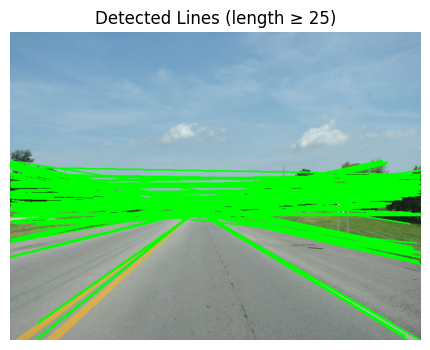

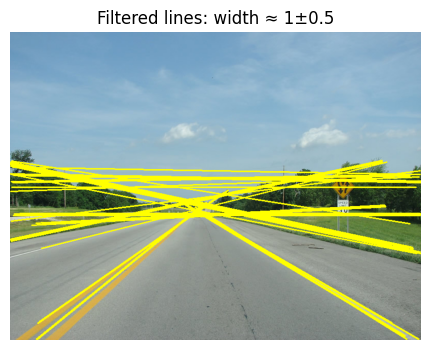

Lines with min length 25: 2
Lines with width ~1±0.5: 38


In [23]:
# Task 3: Apply functions to detect lines
min_length = 25
line_width = 1
width_tolerance = 0.5

lines = detect_lines(image, min_length)
lines_with_width = detect_lines_with_width(image, min_length, line_width, width_tolerance=width_tolerance)

print(f"Lines with min length {min_length}: {len(lines) if lines is not None else 0}")
print(f"Lines with width ~{line_width}±{width_tolerance}: {len(lines_with_width)}")
